compare different cities by their aggregated momepy metrics 

In [1]:
import pandas as pd
import configparser
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re

In [2]:
# Read the configuration file
config = configparser.ConfigParser()
config_file = 'config.ini'

# Check if file exists
if not os.path.isfile(config_file):
    # Create a simple config file
    config['Paths'] = {
        'gdb_folder': '/path/to/your/gdb/folder',
        'output_dir': '/path/to/your/output/folder'
    }
    with open(config_file, 'w') as configfile:
        config.write(configfile)
    print(f"Created configuration file '{config_file}'.")

# Read the configuration file
config.read(config_file)
gdb_folder = config['Paths']['gdb_folder']
output_dir = config['Paths']['output_dir']


In [3]:
def read_csvs_into_dataframe(folder_path):
    result_data = []
    
    # List all files in the given folder
    files = os.listdir(folder_path)
    
    # Filter CSV files that end with folder_path.csv
    csv_files = [f for f in files if f.endswith(f"{os.path.basename(folder_path)}.csv")]
    
    for file in csv_files:
        # Extract the city name (prefix)
        city = file.replace(f"_{os.path.basename(folder_path)}.csv", "")
        
        # Full path to the CSV file
        file_path = os.path.join(folder_path, file)
        
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Compute the mean of the second column
        mean_value = df.iloc[:, 1].median()
        
        # Get the number of rows
        num_rows = len(df)
        
        # Append the data to the result list
        # get the last path component of folder_path
        
        feature_name = os.path.basename(folder_path.rstrip('/'))
        result_data.append({
            'city': city,
            f"{feature_name}_median": mean_value,
            'N': num_rows
        })
    
    # Create a DataFrame from the collected data
    result_df = pd.DataFrame(result_data)
    
    return result_df


In [5]:
def read_features_into_dataframe(folder_path):
    all_dfs = []
    first_df = None
    
    # List all subdirectories in the given folder
    subdirs = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    
    for subdir in subdirs:
        subdir_path = os.path.join(folder_path, subdir)
        df = read_csvs_into_dataframe(subdir_path)
        
        if first_df is None:
            first_df = df
            all_dfs.append(df)
        else:
            # For subsequent dataframes, drop the 'N' column before appending
            all_dfs.append(df.drop(columns=['N']))
    
    # Merge all dataframes
    if all_dfs:
        merged_df = pd.concat(all_dfs, axis=1)
        
        # Remove duplicate 'city' columns
        city_columns = [col for col in merged_df.columns if col.startswith('city')]
        if len(city_columns) > 1:
            merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
        
        # Ensure 'city' is the first column
        cols = merged_df.columns.tolist()
        cols.insert(0, cols.pop(cols.index('city')))
        merged_df = merged_df[cols]
        
        return merged_df
    else:
        return pd.DataFrame()

# Example usage:
# result = read_features_into_dataframe('/path/to/your/main/folder')
# print(result)

In [6]:
# Read all the morphological features
df = read_features_into_dataframe(output_dir)
df['city'] = df['city'].replace("Acre, Israel", "Acre")

# remove the row for Harish
df = df.drop(df[df['city'] == 'Harish'].index)

In [7]:
# add the cities database from Wikipedia
# Source URL: https://he.wikipedia.org/wiki/ערים_בישראל
# Then use this tool to download:
#  https://wikitable2csv.ggor.de
# I then manually translated the column names and saved as CSV
# Use table selector: .toccolours

cities = pd.read_csv('data/cities_israel.csv')
# dictionary of Hebrew to English city names
hebrew_to_english = {
    'ירושלים': 'Jerusalem',
    'תל אביב-יפו': 'Tel Aviv',
    'חיפה': 'Haifa',
    'ראשון לציון': 'Rishon LeZion',
    'פתח תקווה': 'Petah Tikva',
    'אשדוד': 'Ashdod',
    'נתניה': 'Netanya',
    'באר שבע': 'Beer Sheva',
    'בני ברק': 'Bnei Brak',
    'חולון': 'Holon',
    'הרצליה': 'Herzliya',
    'רחובות': 'Rehovot',
    'מודיעין-מכבים-רעות': 'Modiin',
    'חריש': 'Harish',
    'כרמיאל': 'Carmiel',
    'חדרה': 'Hadera',
    'אריאל': 'Ariel',
    'עכו': 'Acre'
}

# Function to translate city names
def translate_city(name):
    return hebrew_to_english.get(name, name)  # If not found, return the original name

# Apply the translation to the 'name' column
cities['name_english'] = cities['name'].apply(translate_city)

# remove various signs
cities_columns = ['name_english', 'area', 'density', 'population', 'growth rate', 'socioeconomic', 'year founded']

for c in cities_columns:
    if c in ['name', 'name_english']:
        continue
    cities[c] = cities[c].astype(str).apply(lambda x: re.sub(r'[%,]', '', x)).astype(float)
    

In [9]:
df = df.merge(right=cities[cities_columns], left_on='city', right_on='name_english', how='left').drop(columns=['name_english'])

In [10]:
def cities_features(df, col1, col2):
    # using plotly, show a scatterplot of the two features, with each row in a different color and a legend
    fig = px.scatter(df, x=col1, y=col2, color='city')
    fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02))
    fig.show()


In [164]:
import sweetviz as sv

# Generate the report
#report = sv.analyze(df)

# Save the report to an HTML file
#report.show_html('sweetviz_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [16]:
cities_features(df, 'neighbor_distance_Q1_median', 'population')

In [12]:
cities_features(df, 'covered_area_median', 'growth rate')

In [14]:
cities_features(df, 'covered_area_median', 'population')


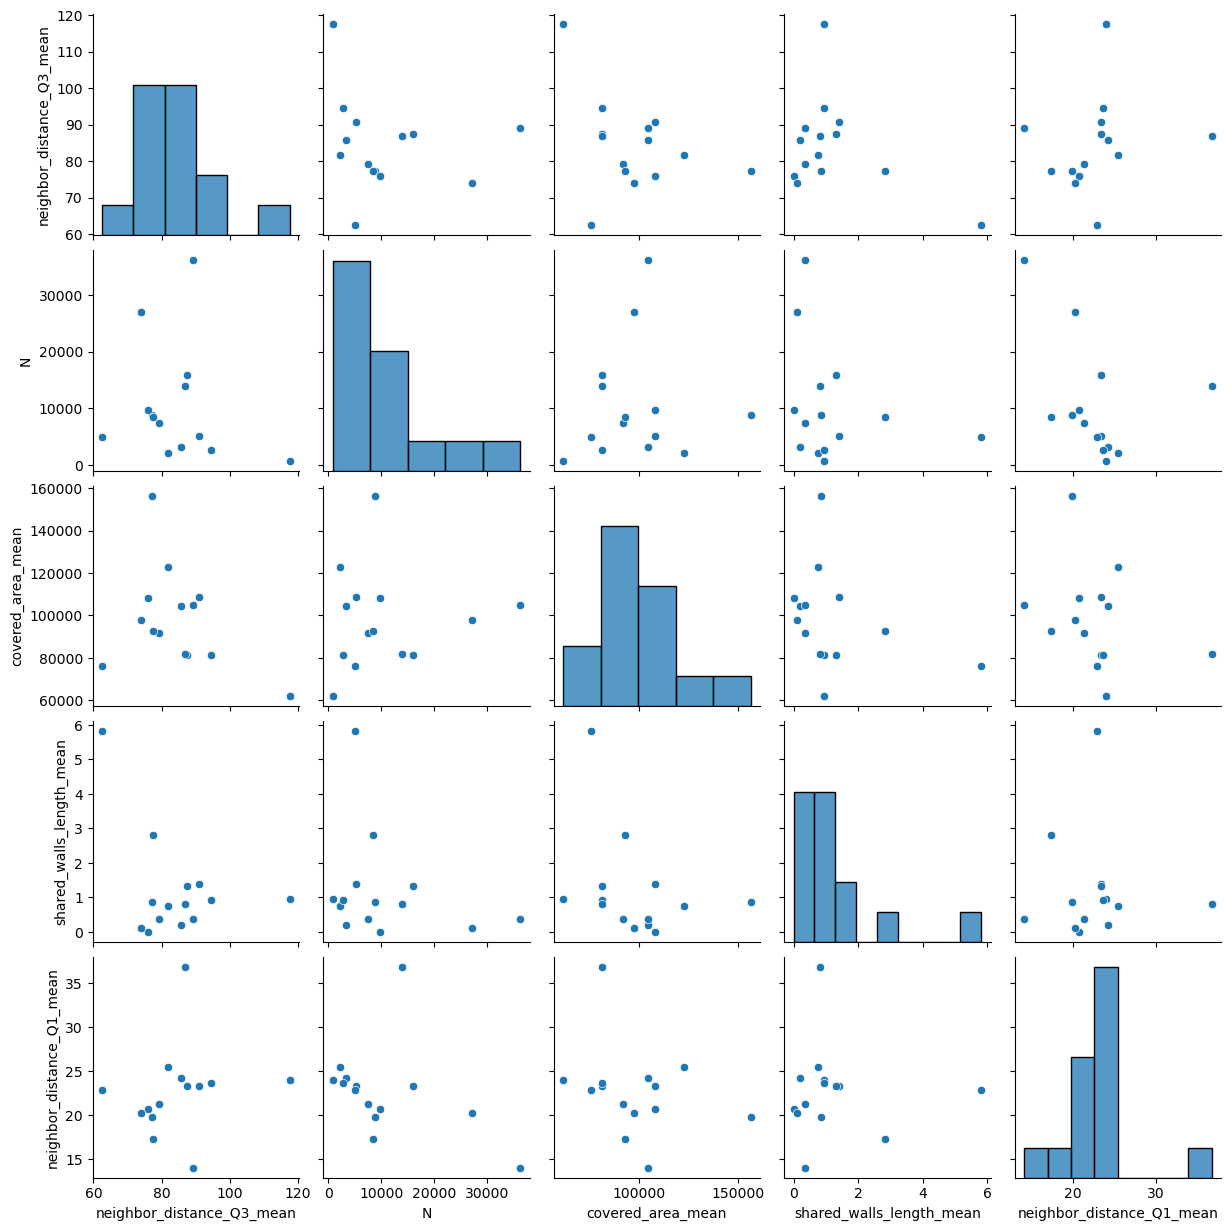

In [19]:
# using seaborn, show pairwise relationships between features of df
# plot each city in a different color and show a legend



import seaborn as sns
sns.pairplot(df)